This cell mounts the Google Drive to the Colab environment, allowing access to files stored in the user's Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the libaries

In [ ]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from skimage.feature import local_binary_pattern
from sklearn.metrics import classification_report, accuracy_score


**Define Constants**

IMG_SIZE = (64, 64)
This constant defines the size to which all input images will be resized—specifically 64 pixels in height and 64 pixels in width. This helps ensure uniformity when processing images for machine learning.

CLASS_NAMES = {0: "Squirrel", 1: "Pigeon", 2: "Macaw"}
This constant is a dictionary that maps numeric labels to the corresponding class names. For example, the number 0 represents "Squirrel", 1 represents "Pigeon", and 2 represents "Macaw". This is useful when interpreting model predictions.

The print() statements
These are used to display the values of the constants to confirm they are set correctly. The output shows the image size and the class label mappings.

In [ ]:
IMG_SIZE = (64, 64)
CLASS_NAMES = {0: "Squirrel", 1: "Pigeon", 2: "Macaw"}
print(IMG_SIZE)
print(CLASS_NAMES)

(64, 64)
{0: 'Squirrel', 1: 'Pigeon', 2: 'Macaw'}


This code finds the best state for the test split

`find_best_random_state(X, y, model_type='svm')`
This function iterates through a range of random states (0 to 99) to find the best random state for splitting the data into training and testing sets. It trains a specified model (`svm` or `knn`) for each random state and calculates the accuracy on the test set. It then plots the accuracy for each random state and prints the best random state found along with its corresponding accuracy.
- `X`: The feature data.
- `y`: The corresponding labels.
- `model_type`: A string specifying the type of model to use ('svm' or 'knn').

In [70]:
def find_best_random_state(X, y, model_type='svm'):
    best_state = 0
    best_score = 0
    scores = []

    for state in range(0, 100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=state)

        if model_type == 'svm':
            model = SVC(kernel='rbf', C=1.0, gamma='scale')
        else:
            model = KNeighborsClassifier(n_neighbors=9)

        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        score = accuracy_score(y_test, preds)
        scores.append(score)

        if score > best_score:
            best_score = score
            best_state = state

    plt.figure(figsize=(10, 5))
    plt.plot(range(0, 100), scores)
    plt.title(f'Best Random state ({model_type.upper()})')
    plt.xlabel('Random State')
    plt.ylabel('Accuracy')
    plt.axvline(x=best_state, color='r', linestyle='--', label=f'Best State: {best_state:.0f}')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\n Best random_state: {best_state} with Accuracy: {best_score:.4f}")
    return best_state

This function is responsible for loading image data from specified directories for each class (Squirrel, Pigeon, Macaw). It calls load_images_from_class for each category, concatenates the data and labels, and then splits the data into training and testing sets using train_test_split. It also calls find_best_random_state to determine the optimal random_state for the split based on SVM model performance.

In [ ]:
def load_data():
    squirrel_path = '/content/drive/MyDrive/Colabs/Project 2/2/Squirrel'
    pigeon_path   = '/content/drive/MyDrive/Colabs/Project 2/2/Pigeon'
    macaw_path    = '/content/drive/MyDrive/Colabs/Project 2/2/Macaw'

    squirrel_data, squirrel_labels = load_images_from_class(squirrel_path, 0)
    pigeon_data, pigeon_labels     = load_images_from_class(pigeon_path, 1)
    macaw_data, macaw_labels       = load_images_from_class(macaw_path, 2)

    X = np.array(squirrel_data + pigeon_data + macaw_data)
    y = np.array(squirrel_labels + pigeon_labels + macaw_labels)



    best_state = find_best_random_state(X, y, model_type='svm')  # or 'knn'
    return train_test_split(X, y, test_size=0.2, random_state=best_state)


This function loads images from a given folder path, extracts features from each image using get_hog_and_color_features, and assigns a specified label value to all images from that folder.

folder_path: The path to the folder containing the images for a specific class.
label_value: The numerical label to assign to the images in this folder.

In [64]:
def load_images_from_class(folder_path, label_value):
    data = []
    labels = []
    for file in os.listdir(folder_path):
        if file.lower().endswith('.jpg'):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)

            features = get_hog_and_color_features(img)
            data.append(features)
            labels.append(label_value)
    return data, labels

Extracts image

In [61]:
def get_hog_and_color_features(image, size=IMG_SIZE):
    # Resize
    resized = cv2.resize(image, size)

    # Convert to grayscale for HOG and LBP
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

    # HOG features
    hog_features, _ = hog(
        gray,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        orientations=9,
        block_norm='L2-Hys',
        visualize=True
    )

    rgb_flattened = resized.flatten() / 255.0

    combined_features = np.append(hog_features, rgb_flattened)



    return combined_features

#### Function: `train_models_and_compare()`
This function orchestrates the training and evaluation of the KNN and SVM models. It first loads the data using `load_data`, then finds the best 'k' for the KNN model using `choose_best_k`. It initializes both models, trains them on the training data, and evaluates their performance on the test data using accuracy and a classification report. It also performs 10-fold cross-validation on the training data for both models.

In [63]:
def train_models_and_compare():
    X_train, X_test, y_train, y_test = load_data()

    best_k = choose_best_k(X_train, y_train)

    models = {
        "knn": KNeighborsClassifier(n_neighbors=best_k),
        "svm": SVC(kernel='rbf', C=1.0, gamma='scale', probability=True,class_weight='balanced')
    }

    for name, model in models.items():
        print("\n")
        print('='*10)
        print(f"Model: {name.upper()}")
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        acc = accuracy_score(y_test, predictions)
        print(f"Test Accuracy: {acc:.4f}")

        print("\nClassification Report:")
        print(classification_report(
            y_test, predictions, target_names=list(CLASS_NAMES.values()), zero_division=0
        ))

        print("\nCross-Validation (10-fold):")
        scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
        print("Scores for each fold:", np.round(scores, 4))
        print("Average Score:", np.mean(scores))
        print('='*10)

    return models

#### Function: `choose_best_k(X, y, k_options=range(1, 11))`
This function determines the optimal number of neighbors ('k') for the K-Nearest Neighbors (KNN) classifier. It performs 10-fold cross-validation for a range of 'k' values (1 to 10) and calculates the average accuracy for each 'k'. It then plots the average accuracy versus 'k' and prints the best 'k' found along with its corresponding average accuracy.
- `X`: The training feature data.
- `y`: The training labels.
- `k_options`: A range of 'k' values to test.

In [68]:
def choose_best_k(X, y, k_options=range(1, 11)):
    best_k = 1
    highest_score = 0
    mean_scores = []
    print("Testing different k values (1 to 10) for KNN...")

    for k in k_options:
        model = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
        mean_score = np.mean(scores)
        mean_scores.append(mean_score)
        print(f"k = {k}, Average Accuracy = {mean_score:.4f}")
        if mean_score > highest_score:
            highest_score = mean_score
            best_k = k

    plt.figure(figsize=(10, 5))
    plt.plot(k_options, mean_scores)
    plt.title('K best score')
    plt.xlabel('K')
    plt.ylabel('Average Accuracy')
    plt.xticks(k_options)
    plt.grid(True)
    plt.show()

    print(f"Best k is {best_k} with accuracy of {highest_score:.4f}")
    return best_k

Pridicting a new image


In [76]:
def predict_all_images_in_folder(folder_path, model):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')]

    print(f"\nFound {len(image_files)} images. Predicting...\n")

    predictions = []

    for img_file in sorted(image_files):
        img_path = os.path.join(folder_path, img_file)
        img = cv2.imread(img_path)

        features = get_hog_and_color_features(img).reshape(1, -1)
        prediction = model.predict(features)[0]
        label = CLASS_NAMES.get(prediction, "Unknown")

        predictions.append((img_file, img, label))

    # Display using subplots
    num_images = len(predictions)
    cols = 6
    rows = math.ceil(num_images / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows)) # Adjusted figure size
    axes = axes.flatten()

    for idx, (img_file, img, label) in enumerate(predictions):
        ax = axes[idx]
        ax.imshow(cv2.cvtColor(cv2.resize(img, IMG_SIZE), cv2.COLOR_BGR2RGB))
        ax.set_title(f"{img_file}\n{label}", fontsize=8) # Reduced font size
        ax.axis("off")

    # Hide any unused subplots
    for i in range(len(predictions), len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Main

K and model testing

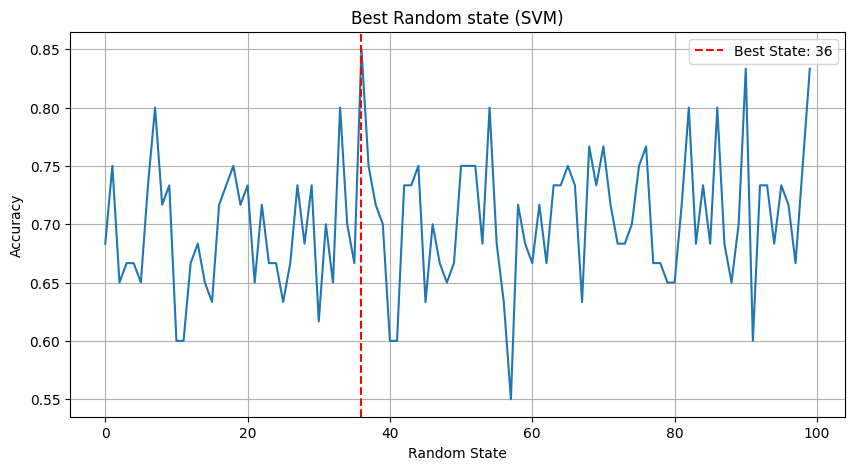


 Best random_state: 36 with Accuracy: 0.8500
Testing different k values (1 to 10) for KNN...
k = 1, Average Accuracy = 0.5417
k = 2, Average Accuracy = 0.5333
k = 3, Average Accuracy = 0.5333
k = 4, Average Accuracy = 0.5375
k = 5, Average Accuracy = 0.5333
k = 6, Average Accuracy = 0.5083
k = 7, Average Accuracy = 0.5292
k = 8, Average Accuracy = 0.5333
k = 9, Average Accuracy = 0.5542
k = 10, Average Accuracy = 0.5500


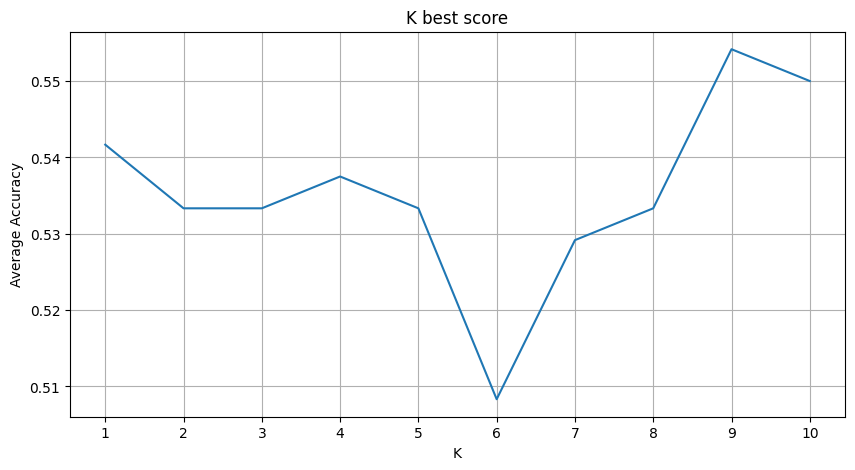

Best k is 9 with accuracy of 0.5542


Model: KNN
Test Accuracy: 0.5167

Classification Report:
              precision    recall  f1-score   support

    Squirrel       0.75      0.50      0.60        24
      Pigeon       0.28      0.62      0.38        13
       Macaw       0.73      0.48      0.58        23

    accuracy                           0.52        60
   macro avg       0.59      0.53      0.52        60
weighted avg       0.64      0.52      0.54        60


Cross-Validation (10-fold):
Scores for each fold: [0.625  0.4583 0.4583 0.625  0.625  0.5833 0.5417 0.5833 0.5    0.5417]
Average Score: 0.5541666666666667


Model: SVM
Test Accuracy: 0.8333

Classification Report:
              precision    recall  f1-score   support

    Squirrel       0.87      0.83      0.85        24
      Pigeon       0.64      0.69      0.67        13
       Macaw       0.91      0.91      0.91        23

    accuracy                           0.83        60
   macro avg       0.81      0.81   

In [71]:
trained_models = train_models_and_compare()


Now testing all unknown images using SVM...

Found 15 images. Predicting...



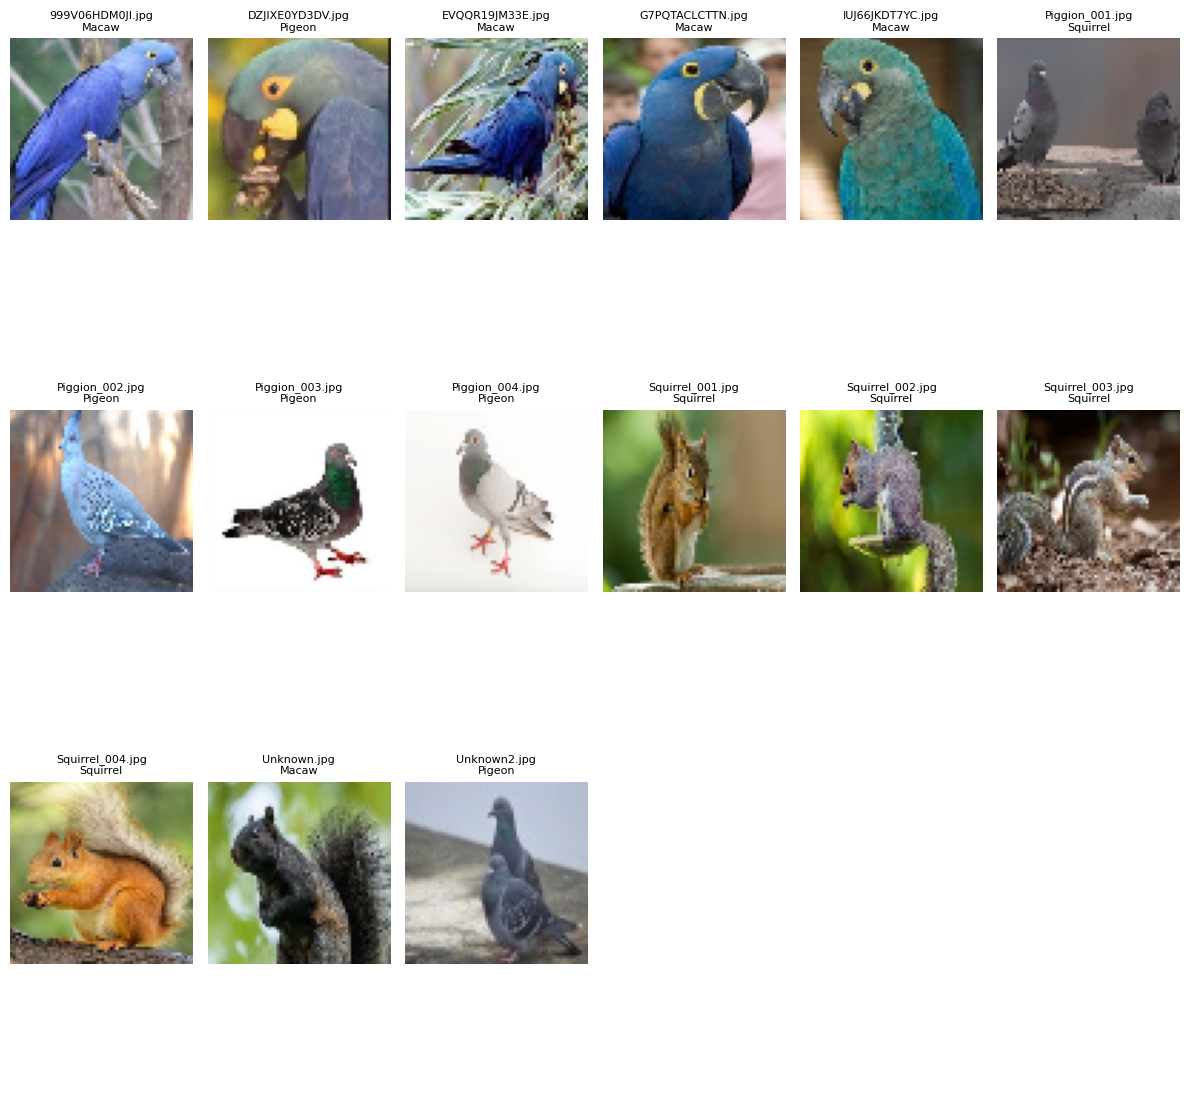

In [77]:
unknown_folder_path = "/content/drive/MyDrive/Colabs/Project 2/DATA/Unknown"
print("\nNow testing all unknown images using SVM...")
predict_all_images_in_folder(unknown_folder_path, trained_models["svm"])